# CIVL 316 - Lab B

In [1]:
import pandas as pd
import numpy as np
from SALib.sample import saltelli
from SALib.analyze import sobol
from math import sqrt
import matplotlib.pyplot as plt

## Deliverables
* Calculation of the energy lost over the hydraulic jump
* Determination of critical depth for the weir and bridge footings.
* Specific Energy and Specific momentum plots for the weir and bridge footing conditions
* The net force acting on the weir and footings in the model
* A sensitivity analysis for critical calculations. Please comment if the exclusion of energy from the theoretical equations is of consequence.
* The sources and magnitudes of error in the determination of loads and energy so an appropriate SF may be applied in designs.

In [2]:
# CONSTANTS
B = 0.156
# Q m3/s conductivity meter
Qsol = 0.0094
# Q m3/s velocity probe
Qpro = 0.012

In [3]:
qsol = Qsol/B
qpro = Qpro/B

In [4]:
print(f"qpsol = {qsol}, qpro = {qpro}")

qpsol = 0.06025641025641026, qpro = 0.07692307692307693


In [5]:
df1 = pd.read_csv("./labB_data.csv")
df2 = pd.read_csv("./labB_data2.csv")

In [6]:
# change all height measurements to meter units
df1[["Weir height", "y1", "y2", "yc", "y3"]] = df1[["Weir height", "y1", "y2", "yc", "y3"]].apply(lambda x: x*0.01)
df2 = df2.apply(lambda x: x*0.01)

In [7]:
df1

,Weir #,Weir height,y1,y2,yc,y3
0,9,0.2290,0.350,0.042,0.103,0.171
1,8,0.2032,0.327,0.045,0.105,0.169
2,7,0.1778,0.302,0.048,0.106,0.164
3,6,0.1524,0.277,0.053,0.111,0.160
4,5,0.1270,0.255,0.056,0.112,0.154
5,4,0.1016,0.230,0.059,0.112,0.147
6,3,0.0762,0.203,0.066,0.110,0.138


In [8]:
df2

,Width,Upstream depth,Downstream depth,Middle depth
0,0.131,0.150,0.079,0.123
1,0.106,0.183,0.072,0.137
2,0.095,0.196,0.067,0.152


## Energy Loss Per Trial

In [9]:
def getEloss(y2, y3):
    Eloss = ((y3-y2)**3)/(4*y2*y3)
    return Eloss

In [10]:
df1["Eloss"] = df1.apply(lambda rows: getEloss(rows["y2"], rows["y3"]), axis=1)
df1

,Weir #,Weir height,y1,y2,yc,y3,Eloss
0,9,0.2290,0.350,0.042,0.103,0.171,0.074725
1,8,0.2032,0.327,0.045,0.105,0.169,0.062677
2,7,0.1778,0.302,0.048,0.106,0.164,0.049571
3,6,0.1524,0.277,0.053,0.111,0.160,0.036116
4,5,0.1270,0.255,0.056,0.112,0.154,0.027284
5,4,0.1016,0.230,0.059,0.112,0.147,0.019643
6,3,0.0762,0.203,0.066,0.110,0.138,0.010245


## Critical Depth: Weir - Measured vs. Theoretical

In [11]:
# measured yc
df1["yc"]

0    0.103
1    0.105
2    0.106
3    0.111
4    0.112
5    0.112
6    0.110
Name: yc, dtype: float64

In [12]:
# theoretical yc
def cbrt(x):
    if 0 <=x: return x**(1./3.)
    return -(-x)**(1./3.)

def getYc(q, g=9.81):
    yc = cbrt((q**2/g))
    return yc

We determine one value for theoretical yc, since specific discharge (q) remains constant due to unchanging flow rate (Q), and unchanging channel width (B)

In [13]:
theo_yc = getYc(qpro)
theo_yc

0.08449183897166887

## Specific Discharge (q): Weir - Measured vs. Theoretical

In [14]:
# measured q
qpro

0.07692307692307693

In [15]:
def getq(yc, g=9.81):
    q = sqrt((yc**3)*g)
    return q

In [16]:
# theoretical q
df1["yc"].apply(getq)

0    0.103536
1    0.106566
2    0.108092
3    0.115829
4    0.117398
5    0.117398
6    0.114268
Name: yc, dtype: float64

## Critical Depth (yc) & Specific Discharge (q): Bridge Footings - Theoretical

In [17]:
def getBCrit(Q, Ec, g=9.81):
    Bc = Q/sqrt((8/27)*g*Ec**3)
    return Bc

In [18]:
def getEc(yc):
    return (3/2) * yc

In [19]:
df2

,Width,Upstream depth,Downstream depth,Middle depth
0,0.131,0.150,0.079,0.123
1,0.106,0.183,0.072,0.137
2,0.095,0.196,0.067,0.152


In [20]:
getYc(Qpro/0.131)

0.09492566125584101

In [21]:
df2["Width"]

0    0.131
1    0.106
2    0.095
Name: Width, dtype: float64

In [22]:
df2["constrict_q"] = df2.apply(lambda rows: Qpro/rows["Width"], axis=1)
df2

,Width,Upstream depth,Downstream depth,Middle depth,constrict_q
0,0.131,0.150,0.079,0.123,0.091603
1,0.106,0.183,0.072,0.137,0.113208
2,0.095,0.196,0.067,0.152,0.126316


In [23]:
df2["Critical depth"] = df2.apply(lambda rows: getYc(Qpro/rows["Width"]), axis=1)
df2

,Width,Upstream depth,Downstream depth,Middle depth,constrict_q,Critical depth
0,0.131,0.150,0.079,0.123,0.091603,0.094926
1,0.106,0.183,0.072,0.137,0.113208,0.109319
2,0.095,0.196,0.067,0.152,0.126316,0.117602


## Part 1: Weir - qpro

In [24]:
def getEnergy(y, q, g=9.81):
    E = y + (q**2/(2*g*y**2))
    return E

In [25]:
# calculate momentum per unit width
def getMomentum(y, q, g=9.81):
    M = (q**2/(g*y)) + (y**2/2)
    return M

In [26]:
getMomentum(0.35, 0.077)

0.06297680937818552

In [27]:
df1.iloc[1].y1

0.327

In [28]:
getEnergy(df1.iloc[6].yc, qpro)

0.13492464159237752

### Specific Energy - Weir

In [29]:
def makeSEplot(arr_q, leftB, rightB, typ):
    vec_energyFunc = np.vectorize(getEnergy)
    for q in arr_q:
        y_vals = np.linspace(leftB, rightB, 100)
        x_vals = vec_energyFunc(y_vals, q)
        plt.plot(x_vals, y_vals, label=f"q = {round(q, 3)}")
    plt.plot(y_vals, y_vals, color="red", linestyle="dotted", label="E = y")
    plt.title(f"Specific Energy vs. Depth - {typ}")
    plt.xlabel("Specific Energy (m)")
    plt.ylabel("Depth (m)")
    plt.legend()
    fig = plt.gcf()
    plt.show()
#     fig.savefig(f"Specific Energy vs. Depth - {typ}_fig.png")

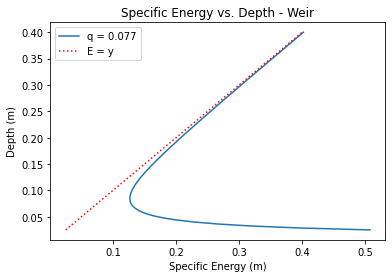

In [30]:
makeSEplot([qpro], 0.025, 0.4, typ="Weir")

### Specific Momentum - Weir

In [31]:
def makeSMplot(arr_q, leftB, rightB, typ):
    vec_energyFunc = np.vectorize(getMomentum)
    for q in arr_q:
        y_vals = np.linspace(leftB, rightB, 100)
        x_vals = vec_energyFunc(y_vals, q)
        plt.plot(x_vals, y_vals, label=f"q = {round(q, 3)}")
    plt.title(f"Specific Momentum vs. Depth - {typ}")
    plt.xlabel("Specific Momentum (m^2)")
    plt.ylabel("Depth (m)")
    plt.legend()
    fig = plt.gcf()
    plt.show()
#     fig.savefig(f"Specific Momentum vs. Depth - {typ}_fig.png")

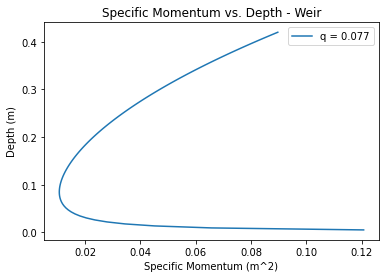

In [32]:
makeSMplot([qpro], 0.005, 0.42, typ="Weir")

## Part 2: Bridge Footings - qpro

### Specific Energy - qpro

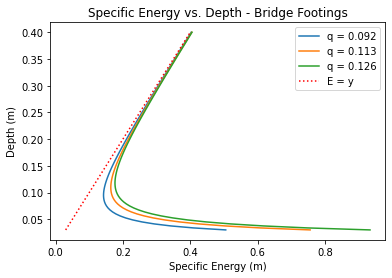

In [33]:
makeSEplot(df2["constrict_q"].tolist(), 0.03, 0.4, typ="Bridge Footings")

### Specific Momentum - qpro

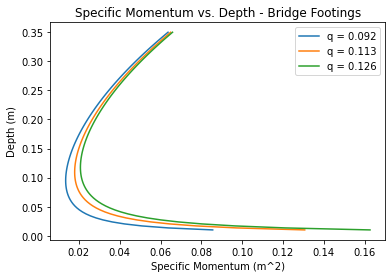

In [34]:
makeSMplot(df2["constrict_q"].tolist(), 0.01, 0.35, typ="Bridge Footings")

## Net Force acting on Weir

In [35]:
# M1 and M2 are momentums per unit width. To get true momentum (and by association, Pf)
# multiply momentums by the channel width, B
def getPf(M1, M2, gamma=9810):
    return (M1-M2)* B * gamma 

In [36]:
df1["Pf"] = df1.apply(lambda rows: 
                      getPf(getMomentum(rows["y1"], qpro), 
                            getMomentum(rows["y2"], qpro)), axis=1)

In [37]:
df1

,Weir #,Weir height,y1,y2,yc,y3,Eloss,Pf
0,9,0.2290,0.350,0.042,0.103,0.171,0.074725,73.044113
1,8,0.2032,0.327,0.045,0.105,0.169,0.062677,62.580487
2,7,0.1778,0.302,0.048,0.106,0.164,0.049571,51.850279
3,6,0.1524,0.277,0.053,0.111,0.160,0.036116,42.477968
4,5,0.1270,0.255,0.056,0.112,0.154,0.027284,34.492618
5,4,0.1016,0.230,0.059,0.112,0.147,0.019643,26.182437
6,3,0.0762,0.203,0.066,0.110,0.138,0.010245,18.760342


## Net Force acting on Bridge Footings

In [38]:
df2["Pf"] = df2.apply(lambda rows: 
                      getPf(getMomentum(rows["Upstream depth"], qpro), 
                            getMomentum(rows["Downstream depth"], qpro)), axis=1)

In [39]:
df2[["Width", "Upstream depth", "Downstream depth", "Pf"]]

,Width,Upstream depth,Downstream depth,Pf
0,0.131,0.150,0.079,6.910390
1,0.106,0.183,0.072,13.882043
2,0.095,0.196,0.067,16.892570


## Sensitivity Analysis

Sensitivity analysis data was taken from weir observation 1. Since our primary focus is on determining the relative impact of each variable on the momentum formula, we simply need a reasonable starting value of y1, y2, Q, and B that can be scaled to determine influence on overall momentum.

In [40]:
scaleFactor = np.array([0.5, 0.75, 1, 1.25, 1.5])
def InputSensitivityPf(baseInd, baseCol, q, scaleF):
    scaledInds = np.array(baseInd * scaleF)
    scaledCols = np.array(baseCol * scaleF)
    data = []
    for ind in scaledInds:
        row = []
        for col in scaledCols:
            Pf = getPf(getMomentum(ind, q), getMomentum(col, q))
            row.append(Pf)
        data.append(row)
    return pd.DataFrame(data=np.array(data), index=scaledInds, columns=scaledCols)

In [41]:
SApf_1 = InputSensitivityPf(df1["y1"][0], df1["y2"][0], qpro, scaleFactor)
SApf_1.index.name = "y1 (m)"
SApf_1.columns.name = "y2 (m)"
SApf_1

y2 (m),0.0210,0.0315,0.0420,0.0525,0.0630
y1 (m),,,,,
0.1750,-15.585126,-1.354916,5.380563,9.016918,11.019349
0.2625,11.948680,26.178889,32.914368,36.550723,38.553154
0.3500,52.078424,66.308633,73.044113,76.680468,78.682899
0.4375,104.276636,118.506845,125.242325,128.878680,130.881110
0.5250,168.367491,182.597700,189.333180,192.969534,194.971965


In [43]:
const_y1 = df1["y1"][0]
const_y2 = df1["y2"][0]
scaledInds = np.array(B * scaleFactor)
scaledCols = np.array(Qpro * scaleFactor)
data = []
for ind in scaledInds:
    row = []
    for col in scaledCols:
        Pf = getPf(getMomentum(const_y1, (col/ind)), getMomentum(const_y2, (col/ind)))
        row.append(Pf)
    data.append(row)
SApf_2 = pd.DataFrame(data=np.array(data), index=scaledInds, columns=scaledCols)

In [44]:
SApf_2.index.name = "B (m)"
SApf_2.columns.name = "Q (m^3/s)"
SApf_2

Q (m^3/s),0.006,0.009,0.012,0.015,0.018
B (m),,,,,
0.078,73.044113,48.868289,15.022135,-28.494348,-81.681162
0.117,83.788924,73.044113,58.001378,38.660719,15.022135
0.156,87.549608,81.505652,73.044113,62.164992,48.868289
0.195,89.290267,85.422135,80.006751,73.044113,64.534223
0.234,90.235810,87.549608,83.788924,78.953759,73.044113


In [45]:
SApf_2.iloc[2]

Q (m^3/s)
0.006    87.549608
0.009    81.505652
0.012    73.044113
0.015    62.164992
0.018    48.868289
Name: 0.156, dtype: float64

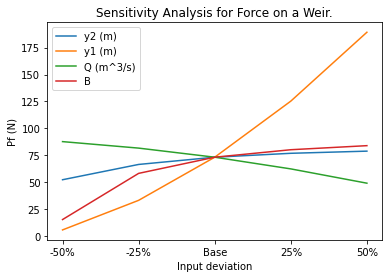

In [46]:
plt.plot(scaleFactor, SApf_1.iloc[2], label="y2 (m)")
plt.plot(scaleFactor, SApf_1[0.0420], label="y1 (m)")
plt.plot(scaleFactor, SApf_2.iloc[2], label="Q (m^3/s)")
plt.plot(scaleFactor, SApf_2[0.012], label="B")

xlabels = ["-50%", "-25%", "Base", "25%", "50%"]

ax = plt.gca()
ax.set_xticks(scaleFactor)
ax.set_xticklabels(xlabels)
plt.legend()
plt.ylabel("Pf (N)")
plt.xlabel("Input deviation")
plt.title("Sensitivity Analysis for Force on a Weir.")
fig = plt.gcf()
plt.show()
# fig.savefig(f"Sensitivity Analysis for Force on a Weir")

In [47]:
def InputSensitivityE(Q, B, scaleF):
    scaledInds = np.array(B * scaleF)
    scaledCols = np.array(Qpro * scaleF)
    data = []
    for ind in scaledInds:
        row = []
        for col in scaledCols:
            q = col/ind
            E = getEnergy(getYc(q), q)
            row.append(E)
        data.append(row)
    return pd.DataFrame(data=np.array(data), index=scaledInds, columns=scaledCols)

In [48]:
SAE = InputSensitivityE(Qpro, B, scaleFactor)
SAE.index.name = "B (m)"
SAE.columns.name = "Q (m^3/s)"
SAE

Q (m^3/s),0.006,0.009,0.012,0.015,0.018
B (m),,,,,
0.078,0.126738,0.166073,0.201184,0.233453,0.263625
0.117,0.096719,0.126738,0.153532,0.178158,0.201184
0.156,0.079840,0.104620,0.126738,0.147066,0.166073
0.195,0.068804,0.090159,0.109219,0.126738,0.143118
0.234,0.060929,0.079840,0.096719,0.112232,0.126738


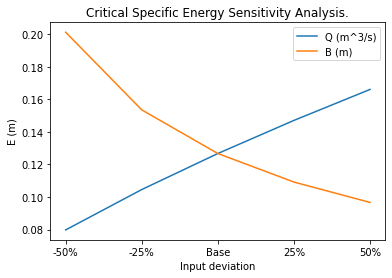

In [49]:
plt.plot(scaleFactor, SAE.iloc[2], label="Q (m^3/s)")
plt.plot(scaleFactor, SAE[0.012], label="B (m)")

xlabels = ["-50%", "-25%", "Base", "25%", "50%"]

ax = plt.gca()
ax.set_xticks(scaleFactor)
ax.set_xticklabels(xlabels)
plt.legend()
plt.ylabel("E (m)")
plt.xlabel("Input deviation")
plt.title("Critical Specific Energy Sensitivity Analysis.")
fig = plt.gcf()
plt.show()
# fig.savefig(f"Critical Specific Energy Sensitivity Analysis")

In [50]:
def InputSensitivityEloss(baseInd, baseCol, scaleF):
    scaledInds = np.array(baseInd * scaleF)
    scaledCols = np.array(baseCol * scaleF)
    data = []
    for ind in scaledInds:
        row = []
        for col in scaledCols:
            Eloss = ((col-ind)**3)/(4*ind*col)
            row.append(Eloss)
        data.append(row)
    return pd.DataFrame(data=np.array(data), index=scaledInds, columns=scaledCols)
SAEloss_1 = InputSensitivityEloss(df1["y2"][0], df1["y3"][0], scaleFactor)

In [51]:
SAEloss_1.index.name = "y2 (m)"
SAEloss_1.columns.name = "y3 (m)"
SAEloss_1

y3 (m),0.08550,0.12825,0.17100,0.21375,0.25650
y2 (m),,,,,
0.0210,0.037362,0.114513,0.234962,0.398839,0.606186
0.0315,0.014617,0.056043,0.125996,0.224764,0.352444
0.0420,0.005730,0.029779,0.074725,0.141083,0.229026
0.0525,0.002002,0.016139,0.046338,0.093406,0.157610
0.0630,0.000529,0.008596,0.029233,0.063601,0.112087


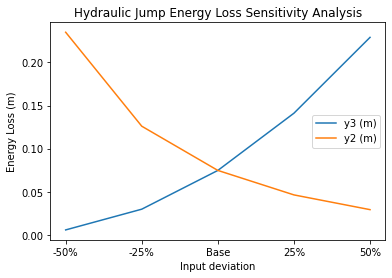

In [52]:
plt.plot(scaleFactor, SAEloss_1.iloc[2], label="y3 (m)")
plt.plot(scaleFactor, SAEloss_1[0.171], label="y2 (m)")

xlabels = ["-50%", "-25%", "Base", "25%", "50%"]

ax = plt.gca()
ax.set_xticks(scaleFactor)
ax.set_xticklabels(xlabels)
plt.legend()
plt.ylabel("Energy Loss (m)")
plt.xlabel("Input deviation")
plt.title("Hydraulic Jump Energy Loss Sensitivity Analysis")
fig = plt.gcf()
plt.show()
# fig.savefig("Hydraulic Jump Energy Loss Sensitivity Analysis")

In [53]:
SAEloss_1.iloc[2]

y3 (m)
0.08550    0.005730
0.12825    0.029779
0.17100    0.074725
0.21375    0.141083
0.25650    0.229026
Name: 0.042, dtype: float64